In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
    auc, roc_curve

from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

from tqdm import tqdm

In [2]:
from NN_utils.Layers.Embedding import Embedding
from NN_utils.Layers.PositionalEncoding import PositionalEncoding
from NN_utils.Layers.SelfAttention import SelfAttention
from NN_utils.Layers.LayerNorm import LayerNorm
from NN_utils.Layers.FeedForward import FeedForward
from NN_utils.Layers.Linear import Linear

from NN_utils.Activations.ReLU import ReLU
from NN_utils.Activations.Softmax import Softmax

from NN_utils.Losses.CrossEntropy import CrossEntropy

In [3]:
seed = 24
rng = np.random.default_rng(seed)

# Data

Toxic Russian Comments From Pikabu and 2ch

URL: https://www.kaggle.com/datasets/aybatov/toxic-russian-comments-from-pikabu-and-2ch?resource=download

This dataset contains some comments from popular russian forums with labels (toxic or not toxic).

1. comment – Original text of comment (Russian Lang)
2. toxic - target, toxic or not (1,0)
3. translated – Yandex translation of original comment to English

In [4]:
raw_data = pd.read_csv('../data/russian_comments_from_2ch_pikabu.csv')

In [5]:
raw_data.shape

(14412, 3)

In [6]:
raw_data.sample(20)

,comment,toxic,translated
314,"Полно таких дебилов, незнающих тему.\n",1.0,"Full of such morons, unaware of the topic."
7504,"Надо же, животное умеет читать..... и даже кла...",1.0,"Wow, the animal can read ..... and even clang..."
7518,"Я вас огорчу ,но это либо тепловой датчик (что...",0.0,"I will disappoint you, but this is either a h..."
9416,А что они такое страшное делают?\n,0.0,And what are they doing so terrible?
9995,"на преображенке был такой домик, в районе б.че...",0.0,"on the preobrazhenka there was such a house, ..."
10741,"скажите, а как белка срет в квартире. Если ее ...",0.0,tell me how the squirrel shit in the apartmen...
12457,"Как верно ниже написали, больше на ристретто п...",0.0,"As correctly written below, it looks more lik..."
12904,"интересно как раз, как они внутри заложены\n",0.0,is interesting just how they are laid inside
13034,А меж тем американцы уже снимают ремейк с Джей...,0.0,"Meanwhile, the Americans are already filming ..."
246,"Пойдешь за зарплатой, вазелин захвати, так дру...",0.0,"You’ll go get your salary, take Vaseline, so ..."


In [7]:
raw_data.toxic.unique()

array([1., 0.])

In [8]:
raw_data.toxic.value_counts()

toxic
0.0    9586
1.0    4826
Name: count, dtype: int64

<Axes: xlabel='toxic', ylabel='count'>

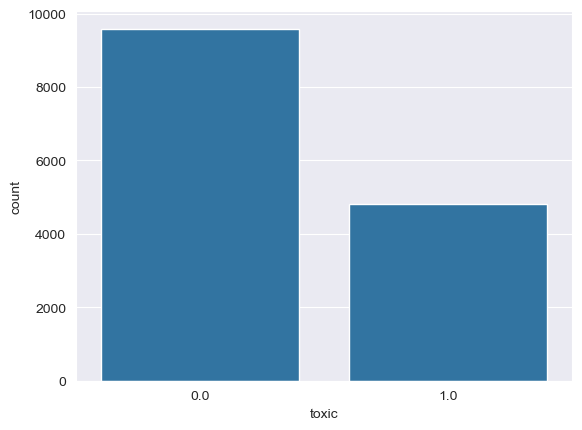

In [9]:
sns.countplot(raw_data, x='toxic')

In [10]:
raw_data.comment.sample(10)

13764                     Он платить за хохлов не будет.\n
2199     Это тральская картинка, довнич. Почитай иностр...
1717     Наверно потому что на двачах мало школьников и...
9695     Ну я и сам не в этой стране живу, где жизнь по...
10702    так получилось что послушал один рассказ, у од...
733      Ну видимо в микротике не реализован автопоиск ...
984      , ау! Вы где? Ни одного ответа никому в треде....
12582    Как она может вылить к вымиранию? Больше младе...
8125     История интересная, но нам ой взгляд изложение...
13611    Очевидно же. Вата массово затыкает анусы, чтоб...
Name: comment, dtype: object

In [11]:
raw_data[raw_data.toxic == 1].comment.sample(10)

14132    Реальная фамилия Шульженок. Лол, опять хохлы з...
7204     Еблан. Ты погугли сколько арийцев обожранных д...
5913     А сейчас смотрит хуйню всякую с пидорасом звон...
2125     Жечь живьём вас скоро блядей антироссийских бу...
13890    Вся суть этой дерьмостраны. Ещё и тут лахтадыр...
2882     готовься к санкциям Не проецируй, пидораха. Ра...
716      лол, классическое народ не тот . Корону с башк...
13593    Нофый Натащьк прибыл. Типеря не руським будит ...
748      А вы кто тут вообще? Мы как бы рассуждаем в ве...
122                  я их маму ибаль, мааааааааматкунем!\n
Name: comment, dtype: object

There are no missing values

In [12]:
raw_data.isnull().sum()

comment       0
toxic         0
translated    0
dtype: int64

In [13]:
raw_data['translated_symbols_length'] = raw_data.translated.apply(lambda x: len(x))
raw_data['comment_symbols_length'] = raw_data.comment.apply(lambda x: len(x))

In [14]:
raw_data[['comment_symbols_length', 'translated_symbols_length']].describe()

,comment_symbols_length,translated_symbols_length
count,14412.000000,14412.000000
mean,176.525812,194.373925
std,271.612376,290.074476
min,21.000000,2.000000
25%,57.000000,64.000000
50%,101.000000,113.000000
75%,197.000000,218.000000
max,7404.000000,7636.000000


Text(0.5, 0.98, 'Length in symbols')

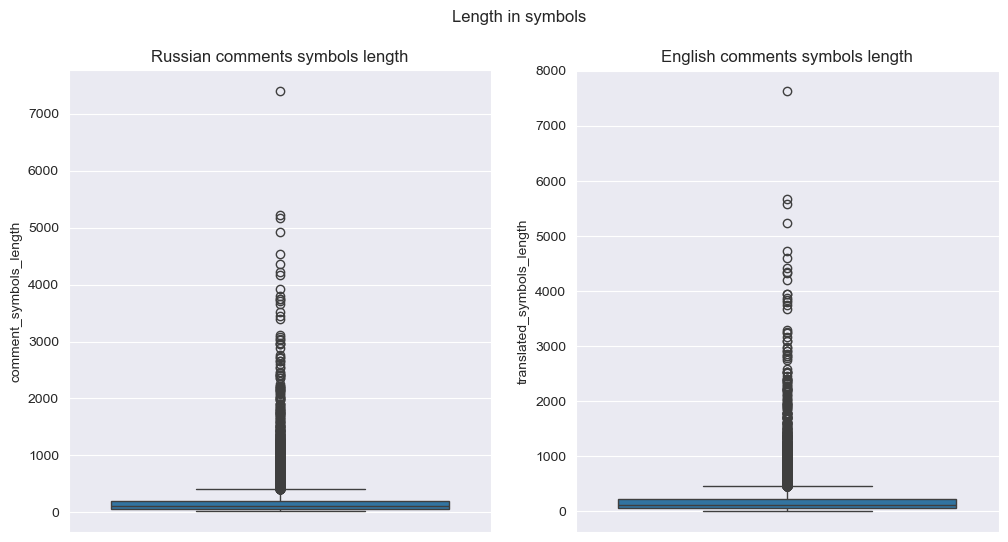

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=raw_data, y='comment_symbols_length', ax=axes[0])
axes[0].set_title('Russian comments symbols length')

sns.boxplot(data=raw_data, y='translated_symbols_length', ax=axes[1])
axes[1].set_title('English comments symbols length')

fig.suptitle('Length in symbols')

# Prepare dataset
## Create tokenizer

In [16]:
VOCAB_SIZE = 5000

In [17]:
class MyTokenizer:
    def __init__(self, vocab_size=3000, min_frequency=2):
        self.vocab_size = vocab_size
        self.min_frequency = min_frequency
        self.tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
        self.tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
        self.tokenizer.decoder = decoders.WordPiece()
        self.tokenizer.trainer = trainers.WordPieceTrainer(
            special_tokens=["[UNK]", "[SEP]", "[PAD]"],  # no need in "[CLS]", "[MASK]"
            vocab_size=self.vocab_size,
            min_frequency=self.min_frequency
        )

    def fit(self, text):
        self.tokenizer.train_from_iterator(text, trainer=self.tokenizer.trainer)

    def encode(self, text):
        return self.tokenizer.encode(text).ids

    def decode(self, ids):
        return self.tokenizer.decode(ids)

    def encode_and_size_up(self, text, max_len, pad_token_id=2):
        encoded_text = self.tokenizer.encode(text).ids
        if len(encoded_text) > max_len:
            return encoded_text[:max_len]
        else:
            return encoded_text + [pad_token_id] * (max_len - len(encoded_text))

## Create dataset of tokens

In [18]:
list_of_comments = raw_data['comment'] \
    .apply(lambda x: x.strip().lower()) \
    .to_list()

In [19]:
list_of_comments

['верблюдов-то за что? дебилы, бл...',
 'хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. если бы хохлов не было, кисель их бы придумал.',
 'собаке - собачья смерть',
 'страницу обнови, дебил. это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. или мы в тебя верим - это ты и твои воображаемые друзья?',
 'тебя не убедил 6-страничный пдф в том, что скрипалей отравила россия? анализировать и думать пытаешься? ватник что ли?)',
 'для каких стан является эталоном современная система здравоохранения рф? для зимбабве? ты тупой? хохлы',
 'в шапке были ссылки на инфу по текущему фильму марвел. эти ссылки были заменены на фразу репортим брипидора, игнорируем его посты. если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.',
 'упад т! там нельзя строить! технологий нет! разворуют как всегда! уже трещинами пош л!

In [20]:
tokenizer = MyTokenizer(vocab_size=VOCAB_SIZE, min_frequency=2)

tokenizer.fit(list_of_comments)

indexed_texts = [tokenizer.encode(text) for text in list_of_comments]
print("Indexed Texts:\n", indexed_texts[:2])

decoded_texts = [tokenizer.decode(ids) for ids in indexed_texts]
print("Decoded Texts:\n", decoded_texts[:2])

vocab = tokenizer.tokenizer.get_vocab()
print("Vocabulary Size:", len(vocab))
print("Sample Vocabulary Entries:\n", {k: vocab[k] for k in list(vocab.keys())[:10]})




Indexed Texts:
 [[596, 1400, 726, 7, 181, 189, 193, 21, 3069, 85, 6, 49, 89, 361], [1542, 6, 198, 214, 274, 261, 185, 2955, 117, 1582, 82, 176, 1882, 4912, 6, 2768, 6, 3934, 6, 48, 67, 1754, 461, 1898, 8, 288, 208, 1754, 165, 383, 6, 491, 462, 172, 438, 208, 2444, 89, 8]]
Decoded Texts:
 ['верблюдов - то за что? дебилы, бл...', 'хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. если бы хохлов не было, кисель их бы придумал.']
Vocabulary Size: 5000
Sample Vocabulary Entries:
 {'выпи': 4204, 'совко': 4816, 'становится': 2716, 'т': 66, 'будете': 4438, 'своему': 4939, '!!!': 1305, 'долла': 2506, '##ые': 2587, '##ый': 2128}


In [21]:
raw_data['comment_tokens_length'] = raw_data.comment.apply(lambda x: len(tokenizer.encode(x)))

In [22]:
raw_data['comment_tokens_length'].describe()

count    14412.000000
mean        49.547322
std         75.720504
min          1.000000
25%         16.000000
50%         29.000000
75%         55.000000
max       1967.000000
Name: comment_tokens_length, dtype: float64

<Axes: ylabel='comment_tokens_length'>

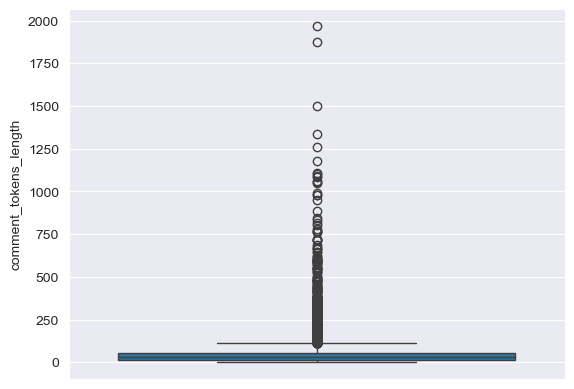

In [23]:
sns.boxplot(raw_data['comment_tokens_length'])

In [24]:
MAX_LEN = 64

In [25]:
raw_data['tokenized_comment'] = raw_data.comment.apply(lambda x: tokenizer.encode_and_size_up(x, max_len=MAX_LEN))

In [26]:
X = raw_data[['tokenized_comment']]
y = raw_data['toxic']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [28]:
print(f'''
    Train : {X_train.shape[0]}
    Test : {X_test.shape[0]}
''')


    Train : 11529
    Test : 2883



In [29]:
y_test.value_counts()

toxic
0.0    1918
1.0     965
Name: count, dtype: int64

Store dataset in NumPy array, where the last element of each row is y

In [30]:
train_dataset = np.column_stack((np.array(X_train['tokenized_comment'].tolist()), y_train.astype(int)))
test_dataset = np.column_stack((np.array(X_test['tokenized_comment'].tolist()), y_test.astype(int)))

In [31]:
train_dataset[:5]

array([[  11,   95,  135,   95,  135,    7,  198,   11,  336,  294, 1769,
         909,  167, 2416,    8,   11, 2690,  183,    3,    0,   50,  682,
         331,   82,   84,   11, 2690,  183,  215, 1896,   21,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    0],
       [   0,   50,  636,    6,  193, 3281,  182,  166, 2838, 1786,  385,
         289,    6, 1482,  588,  414, 3162,  170,  166, 1598,  165,  732,
        2457,  632,    6,   48, 2951, 4104,   94,   94, 2396, 2138,    4,
        1118,    6, 2145, 3179,    6, 4914,  213,  104,  182, 4831,  630,
          56,    8,   52,   91,  637,    0, 3408,  214,    0,   50,  298,
        2109,   56,  903,  167, 4013,  222,  391, 1303,  244,    0],
       [   0,    6,  588,  370,  217,  167, 2179, 1007,   81,    6,   65,
        2466,   87, 2243,  224, 1345,  180,    8

# Build model

In [32]:
class TransformerBlock:
    def __init__(self, embed_size: int, random_seed: int = 21) -> None:
        self.attention = SelfAttention(input_dim=embed_size, random_seed=random_seed)
        self.layer_norm_1 = LayerNorm(embed_size=embed_size)
        self.ffn = FeedForward(d_model=embed_size, d_ff=embed_size * 2, random_seed=random_seed)
        self.layer_norm_2 = LayerNorm(embed_size=embed_size)

    def feedforward(self, x: np.ndarray) -> np.ndarray:
        # PreLN
        self.x = x
        self.x_norm = self.layer_norm_1.feedforward(self.x)
        self.x_att = self.attention.feedforward(self.x_norm)

        # Skip connection
        self.x_1 = self.x + self.x_att
        self.x_1_norm = self.layer_norm_2.feedforward(self.x_1)
        self.x_ff = self.ffn.feedforward(self.x_1_norm)

        return self.x_1 + self.x_ff

    def backprop(self, delta: np.ndarray, lr: float) -> np.ndarray:
        d_x_1_norm = self.ffn.backprop(delta=delta, lr=lr)
        d_x_1 = delta + self.layer_norm_2.backprop(delta=d_x_1_norm, lr=lr)

        d_x_norm = self.attention.backprop(delta=d_x_1, lr=lr)
        return d_x_1 + self.layer_norm_1.backprop(delta=d_x_norm, lr=lr)


In [33]:
class ToxicTransformerClassificator:
    def __init__(self, vocab_size: int, max_len: int, embed_size: int, random_seed: int = 21) -> None:
        self.max_len = max_len
        self.embed_size = embed_size

        self.layers = [
            Embedding(num_embeddings=vocab_size, embedding_dim=embed_size, random_seed=random_seed),
            PositionalEncoding(embed_size=embed_size, max_len=max_len),
            TransformerBlock(embed_size=embed_size, random_seed=random_seed)
        ]

        self.head = [
            Linear(in_neurons=128, out_neurons=64, random_seed=random_seed),
            ReLU(),
            Linear(in_neurons=64,out_neurons=2, random_seed=random_seed),
            Softmax()
        ]

    def feedforward(self, x: np.ndarray) -> np.ndarray:
        self.x = x

        for layer in self.layers:
            x = layer.feedforward(x)

        # Mean pooling
        x_pooled = np.mean(x, axis=0).reshape(-1, 1)

        for layer in self.head:
            x_pooled = layer.feedforward(x_pooled)

        return x_pooled

    def backprop(self, delta: np.ndarray, lr: float) -> None:
        d_ouput = delta
        for layer in reversed(self.head):
            d_ouput = layer.backprop(delta=d_ouput,lr=lr)

        d_ouput = np.repeat(d_ouput.reshape(-1)[np.newaxis, :], self.max_len, axis=0) / self.max_len

        for layer in reversed(self.layers):
            d_ouput = layer.backprop(delta=d_ouput, lr=lr)

# Train

In [34]:
loss = CrossEntropy()

In [35]:
epochs = 4
lr = 1e-3

In [36]:
model = ToxicTransformerClassificator(vocab_size=VOCAB_SIZE, max_len=MAX_LEN, embed_size=128, random_seed=seed)

In [37]:
train_loss_history = []
test_loss_history = []

In [38]:
def train(model : ToxicTransformerClassificator, epochs: int = 1, lr: float = 1e-3) -> None:
    one_hot_matrix = np.eye(np.unique(y).shape[0])

    for epoch in range(epochs):
        # Train phase
        train_loss_value, test_loss_value = 0, 0


        rng.shuffle(train_dataset)
        for i in tqdm(train_dataset):
            y_pred = model.feedforward(i[:-1])
            y_true = one_hot_matrix[i[-1]].reshape(-1, 1)

            train_loss_value += loss.fn(y_true, y_pred)
            delta = loss.dfn(y_true, y_pred)
            model.backprop(delta=delta, lr=lr)


        # Test phase
        for i in tqdm(test_dataset):
            y_pred = model.feedforward(i[:-1])
            y_true = one_hot_matrix[i[-1]].reshape(-1, 1)

            test_loss_value += loss.fn(y_true, y_pred)

        train_loss_value /= train_dataset.shape[0]
        test_loss_value /= test_dataset.shape[0]

        train_loss_history.append(train_loss_value)
        test_loss_history.append(test_loss_value)

In [39]:
train(model=model, epochs=epochs, lr=lr)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 2883/2883 [00:03<00:00, 757.47it/s]


Text(0, 0.5, 'Cross-entropy')

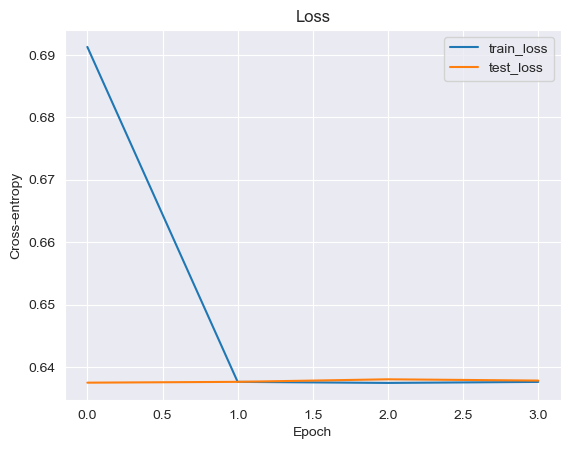

In [40]:
plt.plot(train_loss_history, label="train_loss")
plt.plot(test_loss_history, label="test_loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy')

In [41]:
def predict():
    one_hot_matrix = np.eye(np.unique(y).shape[0])
    y_preds = []
    y_trues = []

    for i in tqdm(test_dataset):
        y_preds.append(model.feedforward(i[:-1]))
        y_trues.append(one_hot_matrix[i[-1]].reshape(-1, 1))

    return np.array(y_preds), np.array(y_trues)

In [42]:
y_pred, y_true = predict()

100%|██████████| 2883/2883 [00:04<00:00, 704.71it/s]


In [43]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

In [44]:
accuracy_score(y_pred_classes, y_test_classes)

0.6649323621227887

In [45]:
print(classification_report(y_test_classes, y_pred_classes,target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.67      1.00      0.80      1918
       toxic       0.00      0.00      0.00       965

    accuracy                           0.66      2883
   macro avg       0.33      0.50      0.40      2883
weighted avg       0.44      0.66      0.53      2883



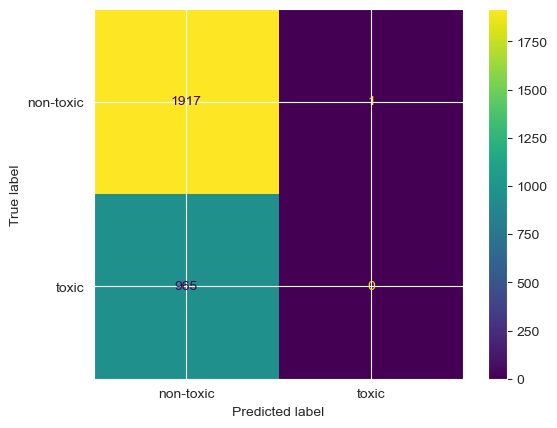

In [46]:
cm = confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic']).plot()

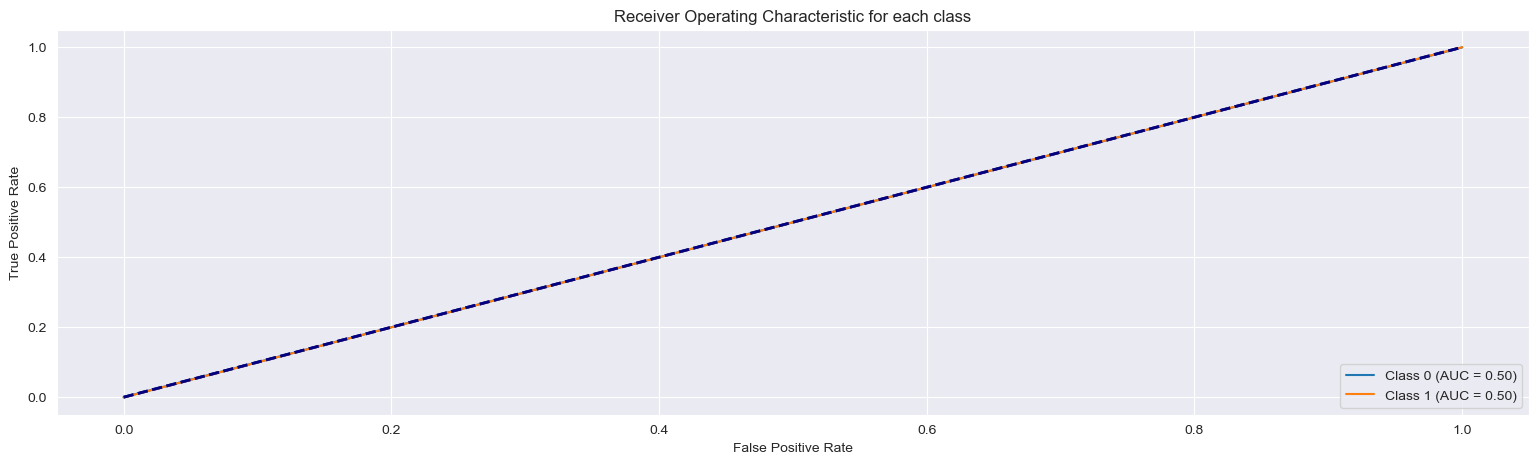

In [47]:
fig, ax = plt.subplots(figsize=(19, 5))

for i in range(2):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = round(auc(fpr, tpr), 4)

    ax.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(i, roc_auc))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic for each class')
ax.legend(loc="lower right")

For debugging

In [48]:
input_ids = [101, 57, 35, 11, 18, 22, 91, 102]

max_len = 8
embed_size = 128

In [49]:
embedLayer = Embedding(num_embeddings=110, embedding_dim=embed_size, random_seed=42)
positionalLayer = PositionalEncoding(embed_size=embed_size, max_len=max_len)
attention = SelfAttention(input_dim=embed_size)
layer_norm = LayerNorm(embed_size=embed_size)

In [50]:
embeddings = embedLayer.feedforward(input_ids)
print(f'after embeddings: {embeddings.shape}')
embeddings_with_positions = positionalLayer.feedforward(embeddings)
print(f'after positional enc: {embeddings_with_positions.shape}')
post_attentions = attention.feedforward(embeddings_with_positions)
print(f'after attentions: {post_attentions.shape}')
res = layer_norm.feedforward(post_attentions)
print(f'after layer_norm: {res.shape}')

after embeddings: (8, 128)
after positional enc: (8, 128)
after attentions: (8, 128)
after layer_norm: (8, 128)
